### **Resumo do Experimento #5: Comparativo U-Net vs. DeepLabv3**

* **Objetivo:** Comparar o desempenho da arquitetura U-Net com a arquitetura DeepLabv3 (com backbone ResNet-50 pré-treinado) para a tarefa de segmentação de tomates, mantendo todos os demais hiperparâmetros constantes para uma avaliação justa.

* **Arquitetura do Modelo:**
    * **DeepLabv3** com backbone **ResNet-50 pré-treinado** no dataset COCO.

* **Configuração do Treinamento:**
    * **Função de Perda:** Dice + BCE Loss (`DiceBCELoss`)
    * **Otimizador:** Adam
    * **Taxa de Aprendizado Inicial:** `1e-4`
    * **Batch Size:** `4`
    * **Número Máximo de Épocas:** `100`

* **Agendador de Taxa de Aprendizado (Scheduler):**
    * **Estratégia:** `ReduceLROnPlateau`
    * **Métrica Monitorada:** `Validation IoU`
    * **Paciência:** `5` épocas
    * **Fator de Redução:** `0.2`

In [41]:
# CELULA 1
# Importar as bibliotecas necessárias
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import concurrent.futures
import csv
import pandas as pd
import seaborn as sns

In [42]:
# CELULA 2
# Defina os caminhos
SOURCE_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
TARGET_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" # Nova pasta
TARGET_SIZE = (256, 256)

# print(f"Criando nova estrutura de pastas em: {TARGET_DATA_DIR}")
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/masks"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/masks"), exist_ok=True)

# def process_single_image(args):
#     filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder = args
#     try:
#         with Image.open(os.path.join(source_img_folder, filename)) as img:
#             img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
#             img_resized.save(os.path.join(target_img_folder, filename))

#         mask_filename = filename.replace(".jpg", ".png")
#         mask_path = os.path.join(source_mask_folder, mask_filename)
#         if not os.path.exists(mask_path):
#             mask_path = os.path.join(source_mask_folder, filename) # Tenta o mesmo nome

#         with Image.open(mask_path) as mask:
#             mask_resized = mask.resize(TARGET_SIZE, Image.NEAREST)
#             mask_resized.save(os.path.join(target_mask_folder, mask_filename))
#     except Exception as e:
#         print(f"Erro ao processar {filename}: {e}")

# def preprocess_dataset(subset):
#     print(f"\nProcessando o conjunto de dados: {subset}")
#     source_img_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/images")
#     source_mask_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/masks")
#     target_img_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/images")
#     target_mask_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/masks")
#     image_files = os.listdir(source_img_folder)

#     args_list = [
#         (filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder)
#         for filename in image_files
#     ]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         list(tqdm(executor.map(process_single_image, args_list), total=len(args_list), desc=f"Redimensionando {subset} images"))

# # Executar para treino e validação
# preprocess_dataset("train")
# preprocess_dataset("validation")

# print("\nPré-processamento concluído!")

In [43]:
# CELULA 3
# --- Configurações do Ambiente e Caminhos ---
# Certifique-se de que este caminho aponta para os dados pré-processados
DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" 
MODEL_SAVE_PATH = "./tomato_deeplabv3_best.pth"  # O modelo será salvo com este nome
CSV_LOG_PATH = "./training_log.csv"      # O log será salvo aqui
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {DEVICE}")

# --- Hiperparâmetros para o Treinamento v2 ---
config = {
    "LEARNING_RATE": 1e-4,       # LR inicial. O scheduler vai ajustá-lo.
    "BATCH_SIZE": 4,
    "NUM_EPOCHS": 100,            
    "IMAGE_HEIGHT": 256,
    "IMAGE_WIDTH": 256,
    "OPTIMIZER": "Adam",
    "LOSS_FUNCTION": "DiceBCE"
}

# NOVO: Configuração do Agendador de Taxa de Aprendizado (Scheduler)
scheduler_config = {
    "factor": 0.2,               # Fator de redução do LR (new_lr = lr * factor). 0.1 ou 0.2 são comuns.
    "patience": 5,               # Nº de épocas sem melhora no val_iou para reduzir o LR.
    "min_lr": 1e-7,              # Taxa de aprendizado mínima.
    "verbose": True              # Imprime uma mensagem quando o LR é atualizado.
}

Usando o dispositivo: cuda


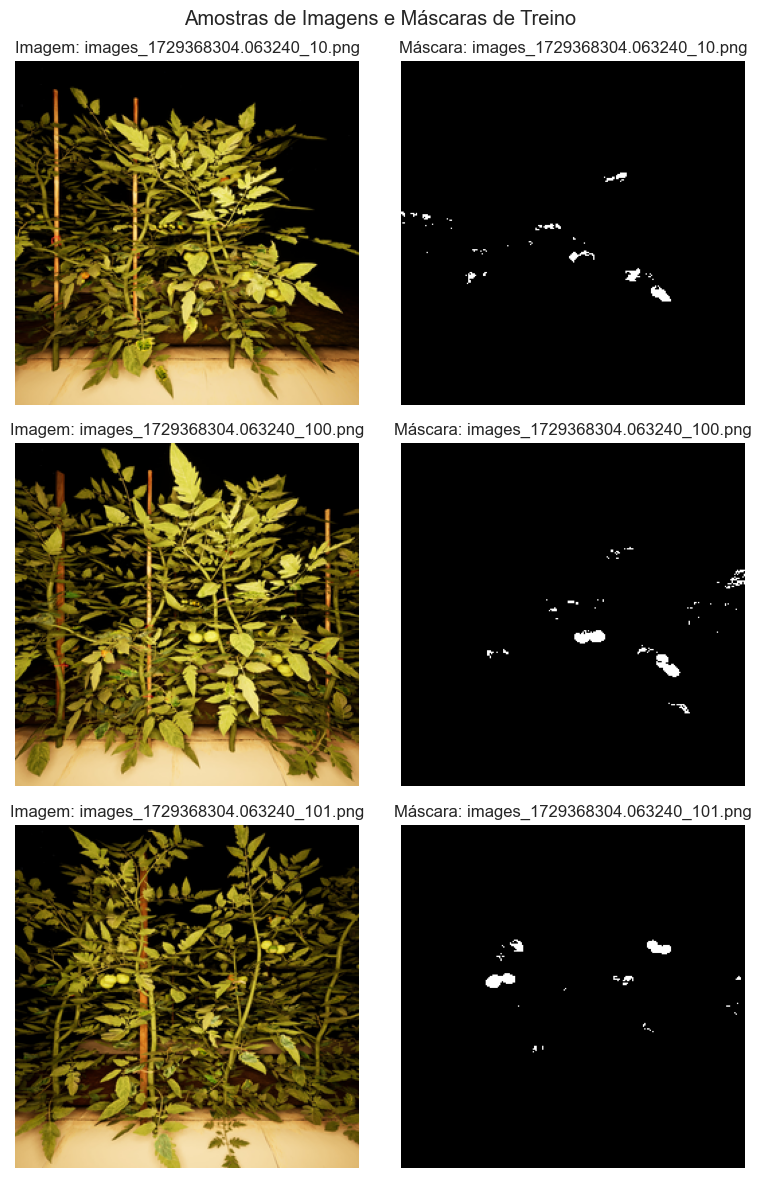

Analisando a proporção de pixels de 'tomate' nas máscaras de treino...


100%|██████████| 100/100 [00:00<00:00, 2699.66it/s]


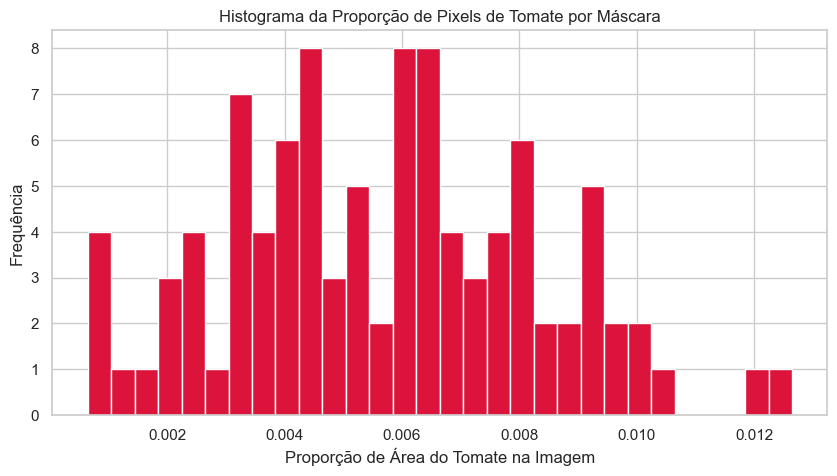

Análise concluída. Média da proporção (em imagens com tomates): 0.0057


In [44]:
# CELULA 4
# a) Pré-processamento, análise estatística dos dados, visualização

# Vamos visualizar algumas imagens e máscaras para entender os dados
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")

# Pegar uma lista de imagens (assumindo que os nomes correspondem)
sample_images = os.listdir(train_img_dir)[:3]

fig, axs = plt.subplots(len(sample_images), 2, figsize=(8, 12))
fig.suptitle('Amostras de Imagens e Máscaras de Treino')

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)
    # Assumindo que a máscara tem o mesmo nome, mas talvez extensão diferente
    # Tente .png ou .jpg se necessário
    mask_path = os.path.join(train_mask_dir, img_name.replace('.jpg', '.png'))
    if not os.path.exists(mask_path):
        mask_path = os.path.join(train_mask_dir, img_name)


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L") # Converter para tons de cinza

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Imagem: {img_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Máscara: {os.path.basename(mask_path)}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Análise Estatística Simples: Proporção de pixels de tomate
print("Analisando a proporção de pixels de 'tomate' nas máscaras de treino...")
mask_files = os.listdir(train_mask_dir)
tomato_proportions = []
for mask_file in tqdm(mask_files[:100]): # Analisar as primeiras 100 para ser rápido
    mask_path = os.path.join(train_mask_dir, mask_file)
    mask_np = np.array(Image.open(mask_path).convert("L"))
    proportion = np.sum(mask_np > 128) / (mask_np.shape[0] * mask_np.shape[1])
    if proportion > 0: # Apenas se houver tomate
        tomato_proportions.append(proportion)

plt.figure(figsize=(10, 5))
plt.hist(tomato_proportions, bins=30, color='crimson')
plt.title('Histograma da Proporção de Pixels de Tomate por Máscara')
plt.xlabel('Proporção de Área do Tomate na Imagem')
plt.ylabel('Frequência')
plt.show()
print(f"Análise concluída. Média da proporção (em imagens com tomates): {np.mean(tomato_proportions):.4f}")

In [45]:
# CELULA 5
# Classe customizada para carregar os dados
class TomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Tratar extensões diferentes entre imagem e máscara
        mask_name = img_name
        possible_mask_exts = ['.png', '.jpg', '.jpeg']
        for ext in possible_mask_exts:
            if mask_name.endswith(ext):
                base_name = mask_name[:-len(ext)]
                break
        else:
            base_name = mask_name

        mask_path = None
        for ext in possible_mask_exts:
            potential_path = os.path.join(self.mask_dir, base_name + ext)
            if os.path.exists(potential_path):
                mask_path = potential_path
                break

        if mask_path is None:
            # Tenta com o mesmo nome exato se falhar
             mask_path = os.path.join(self.mask_dir, img_name)
             if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem {img_name}")


        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Normalizar máscara para 0.0-1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Definir transformações (redimensionamento e conversão para tensor)
# Para data augmentation, pode-se usar a biblioteca Albumentations
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# Por simplicidade, usaremos torchvision transforms
NUM_WORKERS = 0 # <<<< COMECE COM ESTE VALOR

# --- Transformações ---
# Como você já pré-processou, não precisamos mais do Resize
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


class CustomTomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        # Pega a lista de imagens e cria uma referência para as máscaras
        self.image_files = sorted(os.listdir(image_dir))
        
        # Verificação inicial: Checa se pelo menos a primeira máscara existe
        if len(self.image_files) > 0:
            self._verify_path(0)

    def __len__(self):
        return len(self.image_files)

    def _verify_path(self, index):
        """Função interna para encontrar o caminho correto da máscara."""
        img_name = self.image_files[index]
        base_name, _ = os.path.splitext(img_name)
        
        # Tenta as extensões mais comuns para máscaras
        possible_mask_names = [f"{base_name}.png", f"{base_name}.jpg", f"{base_name}.jpeg"]
        
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.mask_dir, mask_name)
            if os.path.exists(mask_path):
                return mask_path
        
        # Se não encontrar, levanta um erro claro
        raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem '{img_name}'. "
                              f"Procurado por {possible_mask_names} na pasta {self.mask_dir}")

    def __getitem__(self, index):
        try:
            # Caminho da imagem
            img_path = os.path.join(self.image_dir, self.image_files[index])
            
            # Caminho da máscara (verificado pela função interna)
            mask_path = self._verify_path(index)
            
            # Carregar imagem e máscara
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Aplicar transformações
            image = self.img_transform(image)
            mask = self.mask_transform(mask)
            
            # Binarizar a máscara para garantir 0s e 1s
            mask = (mask > 0.5).float()
            
            return image, mask

        except Exception as e:
            print(f"Erro ao carregar o item no índice {index}, arquivo: {self.image_files[index]}")
            # Retornar o erro para que o DataLoader possa lidar com ele (ou pular o item)
            raise e


# Criar Datasets
try:
    # ATENÇÃO: Verifique se o DATA_DIR está apontando para a pasta pré-processada (ex: .../processed_data_256)
    train_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "train/images"),
        mask_dir=os.path.join(DATA_DIR, "train/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    val_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "validation/images"),
        mask_dir=os.path.join(DATA_DIR, "validation/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    print(f"Dataset de treino: {len(train_ds)} amostras.")
    print(f"Dataset de validação: {len(val_ds)} amostras.")
    print(f"DataLoader usando {NUM_WORKERS} workers.")

except Exception as e:
    print(f"Ocorreu um erro ao criar os datasets: {e}")

print(f"Dataset de treino: {len(train_ds)} amostras.")
print(f"Dataset de validação: {len(val_ds)} amostras.")

Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.
DataLoader usando 0 workers.
Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.


In [46]:
# ===================================================================
# CÉLULA 6: DEFINIÇÃO DA FUNÇÃO DE PERDA (SUBSTITUIR)
# ===================================================================

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Aplicar sigmoid para ter probabilidades
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat = inputs_sig.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        bce = nn.BCEWithLogitsLoss()(inputs, targets)
        
        return bce + dice_loss

# Instancia a função de perda para ser usada no treinamento
loss_fn = DiceBCELoss()

print("Classe 'DiceBCELoss' e variável 'loss_fn' definidas e prontas.")

Classe 'DiceBCELoss' e variável 'loss_fn' definidas e prontas.


In [47]:
# ===================================================================
# CÉLULA 7: DEFINIÇÃO DO MODELO DEEPLABV3 (SUBSTITUIR)
# ===================================================================
from torchvision import models

def get_deeplabv3_model(num_classes=1):
    """
    Carrega um modelo DeepLabv3 com um backbone ResNet50 pré-treinado 
    e ajusta a camada final para o nosso número de classes.
    """
    # Carrega o modelo pré-treinado no dataset COCO
    model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
    
    # Substitui a camada final de classificação.
    # A DeepLabv3 com ResNet50 tem 21 classes de saída no classificador.
    # Precisamos mudar para o nosso número de classes (1, para a máscara de tomate).
    # O 'classifier[4]' é a última camada convolucional no cabeçalho do classificador.
    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    
    # O 'aux_classifier' também precisa ser ajustado.
    model.aux_classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    return model

# --- Instancia o modelo para o treinamento ---
model = get_deeplabv3_model(num_classes=1).to(DEVICE)

# Teste rápido para verificar as dimensões da saída
try:
    x = torch.randn(2, 3, 256, 256).to(DEVICE)
    output = model(x)
    # A saída do DeepLabv3 é um dicionário com 'out' e 'aux'
    assert output['out'].shape == (2, 1, 256, 256)
    print("Arquitetura DeepLabv3 carregada e adaptada com sucesso!")
except Exception as e:
    print(f"Ocorreu um erro ao testar a arquitetura: {e}")

Arquitetura DeepLabv3 carregada e adaptada com sucesso!


In [48]:
# ===================================================================
# CÉLULA 8: FUNÇÃO DE TREINAMENTO 'train_fn' (ADICIONAR)
# (Adaptada para DeepLabv3)
# ===================================================================

def train_fn(loader, model, optimizer, loss_fn, scaler):
    """
    Executa o loop de treinamento para uma única época.
    """
    loop = tqdm(loader, desc="Training")
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            # A saída do deeplab é um dicionário. Pegamos a saída principal 'out'.
            predictions = model(data)['out']
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

print("Função 'train_fn' definida e pronta.")

Função 'train_fn' definida e pronta.


In [49]:
# ===================================================================
# CÉLULA 9: FUNÇÃO DE MÉTRICAS 'check_accuracy_and_get_metrics' (ADICIONAR)
# (Adaptada para DeepLabv3)
# ===================================================================

def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    """
    Calcula as métricas de validação (IoU e Dice) para o modelo.
    """
    dice_score = 0
    iou_score = 0
    model.eval() # Garante que o modelo está em modo de avaliação

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            # A saída do deeplab é um dicionário. Pegamos a saída principal 'out'.
            preds_logits = model(x)['out']
            preds = torch.sigmoid(preds_logits)
            preds = (preds > 0.5).float()

            # Calcular Dice e IoU
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)

    # Calcula a média das métricas para todos os lotes
    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)
    
    return avg_iou, avg_dice

print("Função 'check_accuracy_and_get_metrics' definida e pronta.")

Função 'check_accuracy_and_get_metrics' definida e pronta.


In [50]:
# ===================================================================
# CÉLULA 10: LOOP DE TREINAMENTO CORRIGIDO (SUBSTITUIR)
# ===================================================================

# --- SETUP DO OTIMIZADOR E SCHEDULER ---
# As variáveis 'model' e 'loss_fn' já foram definidas nas células anteriores.
# Apenas criamos o otimizador e o scaler para este novo modelo.
optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'max',
    factor=scheduler_config["factor"],
    patience=scheduler_config["patience"],
    min_lr=scheduler_config["min_lr"],
    verbose=True
)

# --- INICIALIZAÇÃO DO LOG ---
best_val_iou = -1.0
with open(CSV_LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'val_iou', 'val_dice', 'learning_rate', 'duration_sec'])
print(f"Arquivo de log criado em: {CSV_LOG_PATH}")


# --- LOOP DE TREINAMENTO ---
print("\n--- Iniciando o Treinamento com DeepLabv3 ---")
for epoch in range(config["NUM_EPOCHS"]):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    # As funções 'train_fn' e 'check_accuracy_and_get_metrics' são chamadas aqui
    model.train()
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    model.eval()
    val_iou, val_dice = check_accuracy_and_get_metrics(val_loader, model, device=DEVICE)
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Imprime o resumo da época
    print(f"\n--- ÉPOCA {epoch+1}/{config['NUM_EPOCHS']} ---")
    print(f"Loss de Treino: {train_loss:.4f} | LR: {current_lr:.2e}")
    print(f"Validação -> IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")
    print(f"Duração da Época: {epoch_duration:.2f} segundos")

    scheduler.step(val_iou)

    # Salva os dados da época no arquivo CSV
    with open(CSV_LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, train_loss, val_iou.item(), val_dice.item(), current_lr, epoch_duration])

    # Salva o melhor modelo
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"** Novo melhor IoU: {best_val_iou:.4f}. Modelo salvo! **")

print("--- Treinamento Concluído ---")

Arquivo de log criado em: ./training_log.csv

--- Iniciando o Treinamento com DeepLabv3 ---


Training: 100%|██████████| 4285/4285 [07:51<00:00,  9.09it/s, loss=0.6]  



--- ÉPOCA 1/100 ---
Loss de Treino: 0.5942 | LR: 1.00e-04
Validação -> IoU: 0.4332 | Dice: 0.5985
Duração da Época: 520.34 segundos
** Novo melhor IoU: 0.4332. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.57it/s, loss=0.499]



--- ÉPOCA 2/100 ---
Loss de Treino: 0.4235 | LR: 1.00e-04
Validação -> IoU: 0.4714 | Dice: 0.6364
Duração da Época: 496.27 segundos
** Novo melhor IoU: 0.4714. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.57it/s, loss=0.33] 



--- ÉPOCA 3/100 ---
Loss de Treino: 0.3950 | LR: 1.00e-04
Validação -> IoU: 0.4866 | Dice: 0.6509
Duração da Época: 496.21 segundos
** Novo melhor IoU: 0.4866. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.318]



--- ÉPOCA 4/100 ---
Loss de Treino: 0.3800 | LR: 1.00e-04
Validação -> IoU: 0.5024 | Dice: 0.6655
Duração da Época: 495.75 segundos
** Novo melhor IoU: 0.5024. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.508]



--- ÉPOCA 5/100 ---
Loss de Treino: 0.3700 | LR: 1.00e-04
Validação -> IoU: 0.5089 | Dice: 0.6716
Duração da Época: 495.96 segundos
** Novo melhor IoU: 0.5089. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.388]



--- ÉPOCA 6/100 ---
Loss de Treino: 0.3613 | LR: 1.00e-04
Validação -> IoU: 0.5144 | Dice: 0.6765
Duração da Época: 495.96 segundos
** Novo melhor IoU: 0.5144. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.437]



--- ÉPOCA 7/100 ---
Loss de Treino: 0.3550 | LR: 1.00e-04
Validação -> IoU: 0.5209 | Dice: 0.6823
Duração da Época: 495.93 segundos
** Novo melhor IoU: 0.5209. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.57it/s, loss=0.357]



--- ÉPOCA 8/100 ---
Loss de Treino: 0.3499 | LR: 1.00e-04
Validação -> IoU: 0.5237 | Dice: 0.6847
Duração da Época: 496.28 segundos
** Novo melhor IoU: 0.5237. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:28<00:00,  9.56it/s, loss=0.255]



--- ÉPOCA 9/100 ---
Loss de Treino: 0.3466 | LR: 1.00e-04
Validação -> IoU: 0.5264 | Dice: 0.6871
Duração da Época: 496.76 segundos
** Novo melhor IoU: 0.5264. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.406]



--- ÉPOCA 10/100 ---
Loss de Treino: 0.3426 | LR: 1.00e-04
Validação -> IoU: 0.5311 | Dice: 0.6912
Duração da Época: 496.08 segundos
** Novo melhor IoU: 0.5311. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.396]



--- ÉPOCA 11/100 ---
Loss de Treino: 0.3396 | LR: 1.00e-04
Validação -> IoU: 0.5353 | Dice: 0.6948
Duração da Época: 495.92 segundos
** Novo melhor IoU: 0.5353. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.439]



--- ÉPOCA 12/100 ---
Loss de Treino: 0.3371 | LR: 1.00e-04
Validação -> IoU: 0.5364 | Dice: 0.6958
Duração da Época: 495.97 segundos
** Novo melhor IoU: 0.5364. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:26<00:00,  9.59it/s, loss=0.417]



--- ÉPOCA 13/100 ---
Loss de Treino: 0.3347 | LR: 1.00e-04
Validação -> IoU: 0.5387 | Dice: 0.6979
Duração da Época: 495.58 segundos
** Novo melhor IoU: 0.5387. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.235]



--- ÉPOCA 14/100 ---
Loss de Treino: 0.3323 | LR: 1.00e-04
Validação -> IoU: 0.5382 | Dice: 0.6972
Duração da Época: 495.73 segundos


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.58it/s, loss=0.264]



--- ÉPOCA 15/100 ---
Loss de Treino: 0.3303 | LR: 1.00e-04
Validação -> IoU: 0.5419 | Dice: 0.7004
Duração da Época: 495.76 segundos
** Novo melhor IoU: 0.5419. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:28<00:00,  9.56it/s, loss=0.293]



--- ÉPOCA 16/100 ---
Loss de Treino: 0.3286 | LR: 1.00e-04
Validação -> IoU: 0.5440 | Dice: 0.7021
Duração da Época: 496.45 segundos
** Novo melhor IoU: 0.5440. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:22<00:00,  9.68it/s, loss=0.336]



--- ÉPOCA 17/100 ---
Loss de Treino: 0.3266 | LR: 1.00e-04
Validação -> IoU: 0.5445 | Dice: 0.7026
Duração da Época: 490.60 segundos
** Novo melhor IoU: 0.5445. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.73it/s, loss=0.276]



--- ÉPOCA 18/100 ---
Loss de Treino: 0.3257 | LR: 1.00e-04
Validação -> IoU: 0.5475 | Dice: 0.7051
Duração da Época: 488.49 segundos
** Novo melhor IoU: 0.5475. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.73it/s, loss=0.329]



--- ÉPOCA 19/100 ---
Loss de Treino: 0.3244 | LR: 1.00e-04
Validação -> IoU: 0.5486 | Dice: 0.7060
Duração da Época: 488.42 segundos
** Novo melhor IoU: 0.5486. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.416]



--- ÉPOCA 20/100 ---
Loss de Treino: 0.3228 | LR: 1.00e-04
Validação -> IoU: 0.5497 | Dice: 0.7069
Duração da Época: 488.66 segundos
** Novo melhor IoU: 0.5497. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.73it/s, loss=0.444]



--- ÉPOCA 21/100 ---
Loss de Treino: 0.3219 | LR: 1.00e-04
Validação -> IoU: 0.5512 | Dice: 0.7082
Duração da Época: 488.50 segundos
** Novo melhor IoU: 0.5512. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.367]



--- ÉPOCA 22/100 ---
Loss de Treino: 0.3208 | LR: 1.00e-04
Validação -> IoU: 0.5517 | Dice: 0.7086
Duração da Época: 488.68 segundos
** Novo melhor IoU: 0.5517. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.45] 



--- ÉPOCA 23/100 ---
Loss de Treino: 0.3200 | LR: 1.00e-04
Validação -> IoU: 0.5535 | Dice: 0.7101
Duração da Época: 488.63 segundos
** Novo melhor IoU: 0.5535. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.72it/s, loss=0.303]



--- ÉPOCA 24/100 ---
Loss de Treino: 0.3184 | LR: 1.00e-04
Validação -> IoU: 0.5535 | Dice: 0.7101
Duração da Época: 489.04 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.226]



--- ÉPOCA 25/100 ---
Loss de Treino: 0.3181 | LR: 1.00e-04
Validação -> IoU: 0.5526 | Dice: 0.7094
Duração da Época: 489.07 segundos


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.452]



--- ÉPOCA 26/100 ---
Loss de Treino: 0.3168 | LR: 1.00e-04
Validação -> IoU: 0.5552 | Dice: 0.7115
Duração da Época: 488.61 segundos
** Novo melhor IoU: 0.5552. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.317]



--- ÉPOCA 27/100 ---
Loss de Treino: 0.3161 | LR: 1.00e-04
Validação -> IoU: 0.5569 | Dice: 0.7129
Duração da Época: 488.73 segundos
** Novo melhor IoU: 0.5569. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.73it/s, loss=0.265]



--- ÉPOCA 28/100 ---
Loss de Treino: 0.3152 | LR: 1.00e-04
Validação -> IoU: 0.5566 | Dice: 0.7127
Duração da Época: 488.61 segundos


Training: 100%|██████████| 4285/4285 [07:22<00:00,  9.69it/s, loss=0.377]



--- ÉPOCA 29/100 ---
Loss de Treino: 0.3152 | LR: 1.00e-04
Validação -> IoU: 0.5579 | Dice: 0.7137
Duração da Época: 490.22 segundos
** Novo melhor IoU: 0.5579. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.72it/s, loss=0.312]



--- ÉPOCA 30/100 ---
Loss de Treino: 0.3141 | LR: 1.00e-04
Validação -> IoU: 0.5581 | Dice: 0.7138
Duração da Época: 489.07 segundos
** Novo melhor IoU: 0.5581. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.467]



--- ÉPOCA 31/100 ---
Loss de Treino: 0.3137 | LR: 1.00e-04
Validação -> IoU: 0.5588 | Dice: 0.7145
Duração da Época: 488.97 segundos
** Novo melhor IoU: 0.5588. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.331]



--- ÉPOCA 32/100 ---
Loss de Treino: 0.3128 | LR: 1.00e-04
Validação -> IoU: 0.5608 | Dice: 0.7161
Duração da Época: 489.65 segundos
** Novo melhor IoU: 0.5608. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.729]



--- ÉPOCA 33/100 ---
Loss de Treino: 0.3117 | LR: 1.00e-04
Validação -> IoU: 0.5614 | Dice: 0.7166
Duração da Época: 489.92 segundos
** Novo melhor IoU: 0.5614. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.42] 



--- ÉPOCA 34/100 ---
Loss de Treino: 0.3112 | LR: 1.00e-04
Validação -> IoU: 0.5616 | Dice: 0.7168
Duração da Época: 488.87 segundos
** Novo melhor IoU: 0.5616. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.493]



--- ÉPOCA 35/100 ---
Loss de Treino: 0.3107 | LR: 1.00e-04
Validação -> IoU: 0.5619 | Dice: 0.7170
Duração da Época: 488.70 segundos
** Novo melhor IoU: 0.5619. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.248]



--- ÉPOCA 36/100 ---
Loss de Treino: 0.3103 | LR: 1.00e-04
Validação -> IoU: 0.5625 | Dice: 0.7175
Duração da Época: 488.83 segundos
** Novo melhor IoU: 0.5625. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.306]



--- ÉPOCA 37/100 ---
Loss de Treino: 0.3096 | LR: 1.00e-04
Validação -> IoU: 0.5636 | Dice: 0.7184
Duração da Época: 488.92 segundos
** Novo melhor IoU: 0.5636. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.273]



--- ÉPOCA 38/100 ---
Loss de Treino: 0.3091 | LR: 1.00e-04
Validação -> IoU: 0.5625 | Dice: 0.7174
Duração da Época: 489.12 segundos


Training: 100%|██████████| 4285/4285 [07:36<00:00,  9.39it/s, loss=0.352]



--- ÉPOCA 39/100 ---
Loss de Treino: 0.3086 | LR: 1.00e-04
Validação -> IoU: 0.5640 | Dice: 0.7187
Duração da Época: 505.28 segundos
** Novo melhor IoU: 0.5640. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:41<00:00,  9.29it/s, loss=0.347]



--- ÉPOCA 40/100 ---
Loss de Treino: 0.3080 | LR: 1.00e-04
Validação -> IoU: 0.5646 | Dice: 0.7192
Duração da Época: 510.60 segundos
** Novo melhor IoU: 0.5646. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:36<00:00,  9.39it/s, loss=0.3]  



--- ÉPOCA 41/100 ---
Loss de Treino: 0.3074 | LR: 1.00e-04
Validação -> IoU: 0.5650 | Dice: 0.7195
Duração da Época: 506.96 segundos
** Novo melhor IoU: 0.5650. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:39<00:00,  9.32it/s, loss=0.313]



--- ÉPOCA 42/100 ---
Loss de Treino: 0.3072 | LR: 1.00e-04
Validação -> IoU: 0.5660 | Dice: 0.7203
Duração da Época: 509.26 segundos
** Novo melhor IoU: 0.5660. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.224]



--- ÉPOCA 43/100 ---
Loss de Treino: 0.3069 | LR: 1.00e-04
Validação -> IoU: 0.5657 | Dice: 0.7200
Duração da Época: 515.38 segundos


Training: 100%|██████████| 4285/4285 [07:38<00:00,  9.34it/s, loss=0.315]



--- ÉPOCA 44/100 ---
Loss de Treino: 0.3066 | LR: 1.00e-04
Validação -> IoU: 0.5652 | Dice: 0.7196
Duração da Época: 507.89 segundos


Training: 100%|██████████| 4285/4285 [07:40<00:00,  9.31it/s, loss=0.317]



--- ÉPOCA 45/100 ---
Loss de Treino: 0.3067 | LR: 1.00e-04
Validação -> IoU: 0.5667 | Dice: 0.7209
Duração da Época: 510.05 segundos
** Novo melhor IoU: 0.5667. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:34<00:00,  9.44it/s, loss=0.333]



--- ÉPOCA 46/100 ---
Loss de Treino: 0.3062 | LR: 1.00e-04
Validação -> IoU: 0.5673 | Dice: 0.7213
Duração da Época: 502.75 segundos
** Novo melhor IoU: 0.5673. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:30<00:00,  9.52it/s, loss=0.358]



--- ÉPOCA 47/100 ---
Loss de Treino: 0.3052 | LR: 1.00e-04
Validação -> IoU: 0.5679 | Dice: 0.7218
Duração da Época: 499.03 segundos
** Novo melhor IoU: 0.5679. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:28<00:00,  9.55it/s, loss=0.271]



--- ÉPOCA 48/100 ---
Loss de Treino: 0.3051 | LR: 1.00e-04
Validação -> IoU: 0.5677 | Dice: 0.7217
Duração da Época: 497.53 segundos


Training: 100%|██████████| 4285/4285 [07:28<00:00,  9.55it/s, loss=0.288]



--- ÉPOCA 49/100 ---
Loss de Treino: 0.3044 | LR: 1.00e-04
Validação -> IoU: 0.5686 | Dice: 0.7224
Duração da Época: 497.72 segundos
** Novo melhor IoU: 0.5686. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:38<00:00,  9.35it/s, loss=0.256]



--- ÉPOCA 50/100 ---
Loss de Treino: 0.3041 | LR: 1.00e-04
Validação -> IoU: 0.5687 | Dice: 0.7226
Duração da Época: 508.03 segundos
** Novo melhor IoU: 0.5687. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:34<00:00,  9.43it/s, loss=0.286]



--- ÉPOCA 51/100 ---
Loss de Treino: 0.3035 | LR: 1.00e-04
Validação -> IoU: 0.5690 | Dice: 0.7227
Duração da Época: 504.42 segundos
** Novo melhor IoU: 0.5690. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:29<00:00,  9.53it/s, loss=0.325]



--- ÉPOCA 52/100 ---
Loss de Treino: 0.3037 | LR: 1.00e-04
Validação -> IoU: 0.5694 | Dice: 0.7231
Duração da Época: 497.81 segundos
** Novo melhor IoU: 0.5694. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:23<00:00,  9.67it/s, loss=0.416]



--- ÉPOCA 53/100 ---
Loss de Treino: 0.3031 | LR: 1.00e-04
Validação -> IoU: 0.5699 | Dice: 0.7235
Duração da Época: 491.16 segundos
** Novo melhor IoU: 0.5699. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.297]



--- ÉPOCA 54/100 ---
Loss de Treino: 0.3033 | LR: 1.00e-04
Validação -> IoU: 0.5700 | Dice: 0.7236
Duração da Época: 488.94 segundos
** Novo melhor IoU: 0.5700. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.389]



--- ÉPOCA 55/100 ---
Loss de Treino: 0.3027 | LR: 1.00e-04
Validação -> IoU: 0.5705 | Dice: 0.7239
Duração da Época: 489.60 segundos
** Novo melhor IoU: 0.5705. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:26<00:00,  9.59it/s, loss=0.331]



--- ÉPOCA 56/100 ---
Loss de Treino: 0.3022 | LR: 1.00e-04
Validação -> IoU: 0.5706 | Dice: 0.7240
Duração da Época: 494.65 segundos
** Novo melhor IoU: 0.5706. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:22<00:00,  9.67it/s, loss=0.333]



--- ÉPOCA 57/100 ---
Loss de Treino: 0.3022 | LR: 1.00e-04
Validação -> IoU: 0.5706 | Dice: 0.7240
Duração da Época: 490.99 segundos
** Novo melhor IoU: 0.5706. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:22<00:00,  9.69it/s, loss=0.299]



--- ÉPOCA 58/100 ---
Loss de Treino: 0.3018 | LR: 1.00e-04
Validação -> IoU: 0.5721 | Dice: 0.7252
Duração da Época: 490.03 segundos
** Novo melhor IoU: 0.5721. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.287]



--- ÉPOCA 59/100 ---
Loss de Treino: 0.3015 | LR: 1.00e-04
Validação -> IoU: 0.5725 | Dice: 0.7255
Duração da Época: 489.29 segundos
** Novo melhor IoU: 0.5725. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.299]



--- ÉPOCA 60/100 ---
Loss de Treino: 0.3006 | LR: 1.00e-04
Validação -> IoU: 0.5719 | Dice: 0.7250
Duração da Época: 489.49 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.394]



--- ÉPOCA 61/100 ---
Loss de Treino: 0.3010 | LR: 1.00e-04
Validação -> IoU: 0.5719 | Dice: 0.7251
Duração da Época: 489.28 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.357]



--- ÉPOCA 62/100 ---
Loss de Treino: 0.3010 | LR: 1.00e-04
Validação -> IoU: 0.5720 | Dice: 0.7251
Duração da Época: 489.33 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.329]



--- ÉPOCA 63/100 ---
Loss de Treino: 0.3002 | LR: 1.00e-04
Validação -> IoU: 0.5729 | Dice: 0.7258
Duração da Época: 489.58 segundos
** Novo melhor IoU: 0.5729. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.33] 



--- ÉPOCA 64/100 ---
Loss de Treino: 0.3002 | LR: 1.00e-04
Validação -> IoU: 0.5732 | Dice: 0.7261
Duração da Época: 489.57 segundos
** Novo melhor IoU: 0.5732. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.283]



--- ÉPOCA 65/100 ---
Loss de Treino: 0.2996 | LR: 1.00e-04
Validação -> IoU: 0.5728 | Dice: 0.7258
Duração da Época: 489.47 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.535]



--- ÉPOCA 66/100 ---
Loss de Treino: 0.2997 | LR: 1.00e-04
Validação -> IoU: 0.5724 | Dice: 0.7255
Duração da Época: 489.45 segundos


Training: 100%|██████████| 4285/4285 [07:27<00:00,  9.57it/s, loss=0.349]



--- ÉPOCA 67/100 ---
Loss de Treino: 0.2993 | LR: 1.00e-04
Validação -> IoU: 0.5742 | Dice: 0.7269
Duração da Época: 495.58 segundos
** Novo melhor IoU: 0.5742. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.266]



--- ÉPOCA 68/100 ---
Loss de Treino: 0.2993 | LR: 1.00e-04
Validação -> IoU: 0.5739 | Dice: 0.7267
Duração da Época: 489.45 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.254]



--- ÉPOCA 69/100 ---
Loss de Treino: 0.2989 | LR: 1.00e-04
Validação -> IoU: 0.5748 | Dice: 0.7274
Duração da Época: 490.00 segundos
** Novo melhor IoU: 0.5748. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.318]



--- ÉPOCA 70/100 ---
Loss de Treino: 0.2991 | LR: 1.00e-04
Validação -> IoU: 0.5734 | Dice: 0.7262
Duração da Época: 489.27 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.355]



--- ÉPOCA 71/100 ---
Loss de Treino: 0.2985 | LR: 1.00e-04
Validação -> IoU: 0.5748 | Dice: 0.7274
Duração da Época: 489.40 segundos
** Novo melhor IoU: 0.5748. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.285]



--- ÉPOCA 72/100 ---
Loss de Treino: 0.2990 | LR: 1.00e-04
Validação -> IoU: 0.5747 | Dice: 0.7273
Duração da Época: 489.55 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.251]



--- ÉPOCA 73/100 ---
Loss de Treino: 0.2983 | LR: 1.00e-04
Validação -> IoU: 0.5749 | Dice: 0.7275
Duração da Época: 489.33 segundos
** Novo melhor IoU: 0.5749. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:20<00:00,  9.72it/s, loss=0.306]



--- ÉPOCA 74/100 ---
Loss de Treino: 0.2981 | LR: 1.00e-04
Validação -> IoU: 0.5753 | Dice: 0.7278
Duração da Época: 488.98 segundos
** Novo melhor IoU: 0.5753. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.268]



--- ÉPOCA 75/100 ---
Loss de Treino: 0.2978 | LR: 1.00e-04
Validação -> IoU: 0.5752 | Dice: 0.7277
Duração da Época: 489.26 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.264]



--- ÉPOCA 76/100 ---
Loss de Treino: 0.2973 | LR: 1.00e-04
Validação -> IoU: 0.5744 | Dice: 0.7270
Duração da Época: 489.26 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.244]



--- ÉPOCA 77/100 ---
Loss de Treino: 0.2976 | LR: 1.00e-04
Validação -> IoU: 0.5756 | Dice: 0.7280
Duração da Época: 489.21 segundos
** Novo melhor IoU: 0.5756. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.343]



--- ÉPOCA 78/100 ---
Loss de Treino: 0.2974 | LR: 1.00e-04
Validação -> IoU: 0.5751 | Dice: 0.7276
Duração da Época: 489.55 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.275]



--- ÉPOCA 79/100 ---
Loss de Treino: 0.2969 | LR: 1.00e-04
Validação -> IoU: 0.5760 | Dice: 0.7283
Duração da Época: 489.88 segundos
** Novo melhor IoU: 0.5760. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.451]



--- ÉPOCA 80/100 ---
Loss de Treino: 0.2968 | LR: 1.00e-04
Validação -> IoU: 0.5761 | Dice: 0.7284
Duração da Época: 489.61 segundos
** Novo melhor IoU: 0.5761. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.43] 



--- ÉPOCA 81/100 ---
Loss de Treino: 0.2966 | LR: 1.00e-04
Validação -> IoU: 0.5758 | Dice: 0.7281
Duração da Época: 489.38 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.234]



--- ÉPOCA 82/100 ---
Loss de Treino: 0.2965 | LR: 1.00e-04
Validação -> IoU: 0.5755 | Dice: 0.7279
Duração da Época: 489.50 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.332]



--- ÉPOCA 83/100 ---
Loss de Treino: 0.2966 | LR: 1.00e-04
Validação -> IoU: 0.5771 | Dice: 0.7292
Duração da Época: 489.27 segundos
** Novo melhor IoU: 0.5771. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.32] 



--- ÉPOCA 84/100 ---
Loss de Treino: 0.2965 | LR: 1.00e-04
Validação -> IoU: 0.5770 | Dice: 0.7291
Duração da Época: 489.14 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.494]



--- ÉPOCA 85/100 ---
Loss de Treino: 0.2964 | LR: 1.00e-04
Validação -> IoU: 0.5776 | Dice: 0.7295
Duração da Época: 489.38 segundos
** Novo melhor IoU: 0.5776. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:22<00:00,  9.69it/s, loss=0.242]



--- ÉPOCA 86/100 ---
Loss de Treino: 0.2960 | LR: 1.00e-04
Validação -> IoU: 0.5774 | Dice: 0.7294
Duração da Época: 490.10 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.425]



--- ÉPOCA 87/100 ---
Loss de Treino: 0.2955 | LR: 1.00e-04
Validação -> IoU: 0.5772 | Dice: 0.7292
Duração da Época: 489.82 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.236]



--- ÉPOCA 88/100 ---
Loss de Treino: 0.2959 | LR: 1.00e-04
Validação -> IoU: 0.5774 | Dice: 0.7294
Duração da Época: 489.57 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.406]



--- ÉPOCA 89/100 ---
Loss de Treino: 0.2952 | LR: 1.00e-04
Validação -> IoU: 0.5784 | Dice: 0.7302
Duração da Época: 489.39 segundos
** Novo melhor IoU: 0.5784. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.356]



--- ÉPOCA 90/100 ---
Loss de Treino: 0.2956 | LR: 1.00e-04
Validação -> IoU: 0.5780 | Dice: 0.7299
Duração da Época: 489.20 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.72it/s, loss=0.296]



--- ÉPOCA 91/100 ---
Loss de Treino: 0.2952 | LR: 1.00e-04
Validação -> IoU: 0.5774 | Dice: 0.7294
Duração da Época: 489.06 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.72it/s, loss=0.298]



--- ÉPOCA 92/100 ---
Loss de Treino: 0.2950 | LR: 1.00e-04
Validação -> IoU: 0.5787 | Dice: 0.7304
Duração da Época: 489.00 segundos
** Novo melhor IoU: 0.5787. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.389]



--- ÉPOCA 93/100 ---
Loss de Treino: 0.2948 | LR: 1.00e-04
Validação -> IoU: 0.5784 | Dice: 0.7302
Duração da Época: 489.47 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.273]



--- ÉPOCA 94/100 ---
Loss de Treino: 0.2951 | LR: 1.00e-04
Validação -> IoU: 0.5787 | Dice: 0.7304
Duração da Época: 489.63 segundos
** Novo melhor IoU: 0.5787. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.348]



--- ÉPOCA 95/100 ---
Loss de Treino: 0.2948 | LR: 1.00e-04
Validação -> IoU: 0.5782 | Dice: 0.7300
Duração da Época: 489.79 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.372]



--- ÉPOCA 96/100 ---
Loss de Treino: 0.2948 | LR: 1.00e-04
Validação -> IoU: 0.5790 | Dice: 0.7307
Duração da Época: 489.56 segundos
** Novo melhor IoU: 0.5790. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.69it/s, loss=0.303]



--- ÉPOCA 97/100 ---
Loss de Treino: 0.2942 | LR: 1.00e-04
Validação -> IoU: 0.5793 | Dice: 0.7309
Duração da Época: 490.01 segundos
** Novo melhor IoU: 0.5793. Modelo salvo! **


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.70it/s, loss=0.274]



--- ÉPOCA 98/100 ---
Loss de Treino: 0.2948 | LR: 1.00e-04
Validação -> IoU: 0.5788 | Dice: 0.7305
Duração da Época: 489.98 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.72it/s, loss=0.217]



--- ÉPOCA 99/100 ---
Loss de Treino: 0.2944 | LR: 1.00e-04
Validação -> IoU: 0.5792 | Dice: 0.7308
Duração da Época: 489.07 segundos


Training: 100%|██████████| 4285/4285 [07:21<00:00,  9.71it/s, loss=0.158]



--- ÉPOCA 100/100 ---
Loss de Treino: 0.2943 | LR: 1.00e-04
Validação -> IoU: 0.5785 | Dice: 0.7302
Duração da Época: 489.20 segundos
--- Treinamento Concluído ---


In [51]:
# ===================================================================
# CÉLULA 9: FUNÇÃO DE MÉTRICAS CORRIGIDA (SUBSTITUIR)
# ===================================================================

def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    """
    Calcula as métricas de validação (IoU e Dice) para o modelo.
    """
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            preds_logits = model(x)['out']
            preds = torch.sigmoid(preds_logits)
            preds = (preds > 0.5).float()

            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)

    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)
    
    return avg_iou, avg_dice

print("Função 'check_accuracy_and_get_metrics' (corrigida) definida e pronta.")

Função 'check_accuracy_and_get_metrics' (corrigida) definida e pronta.


Carregando o melhor modelo DeepLabv3 salvo de './tomato_deeplabv3_best.pth'...
Carregando log de treinamento de './training_log.csv'...
Gerando gráficos de treinamento...


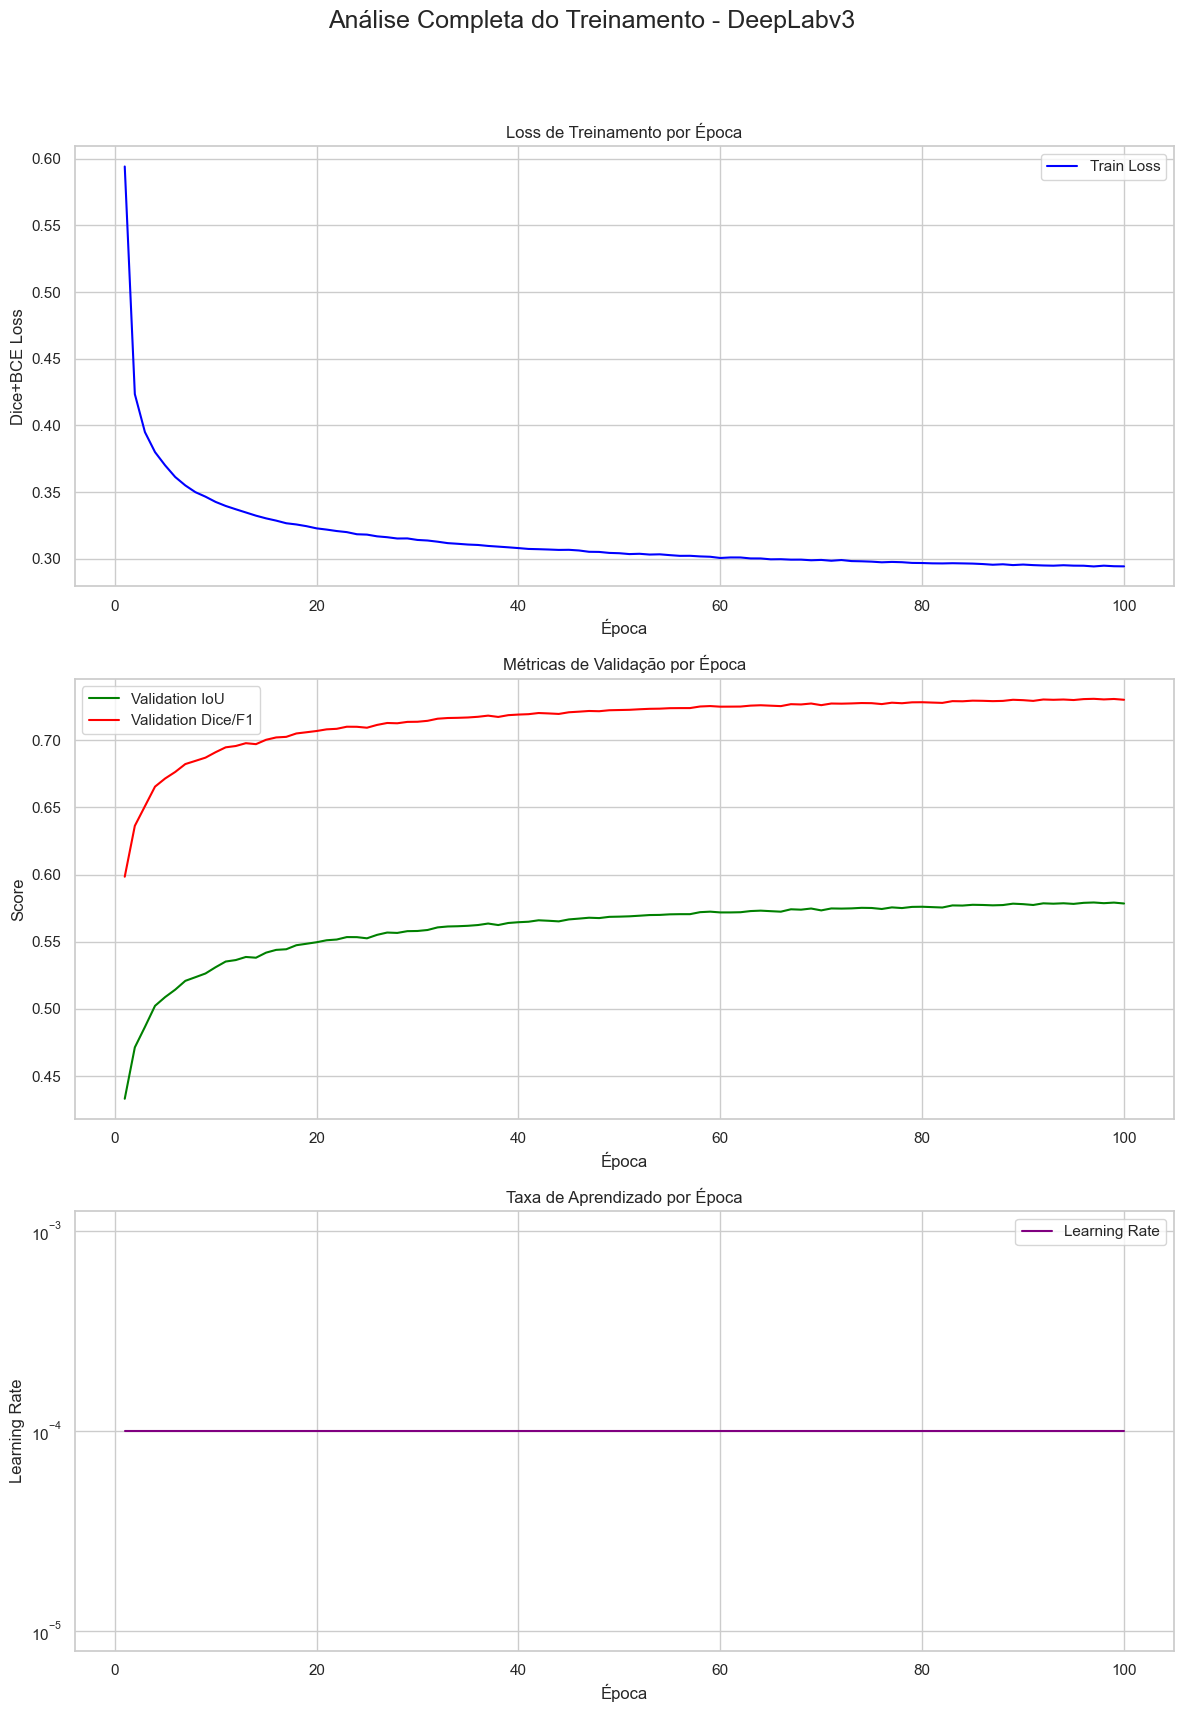


Calculando métricas finais detalhadas no conjunto de validação...


Calculando Métricas Finais: 100%|██████████| 1058/1058 [01:01<00:00, 17.22it/s]



      RESULTADOS FINAIS DO MELHOR MODELO (DeepLabv3)
IoU         : 0.5793
Dice/F1     : 0.7309
Precision   : 0.7516
Recall      : 0.7140

Gerando visualizações de predições do melhor modelo DeepLabv3...


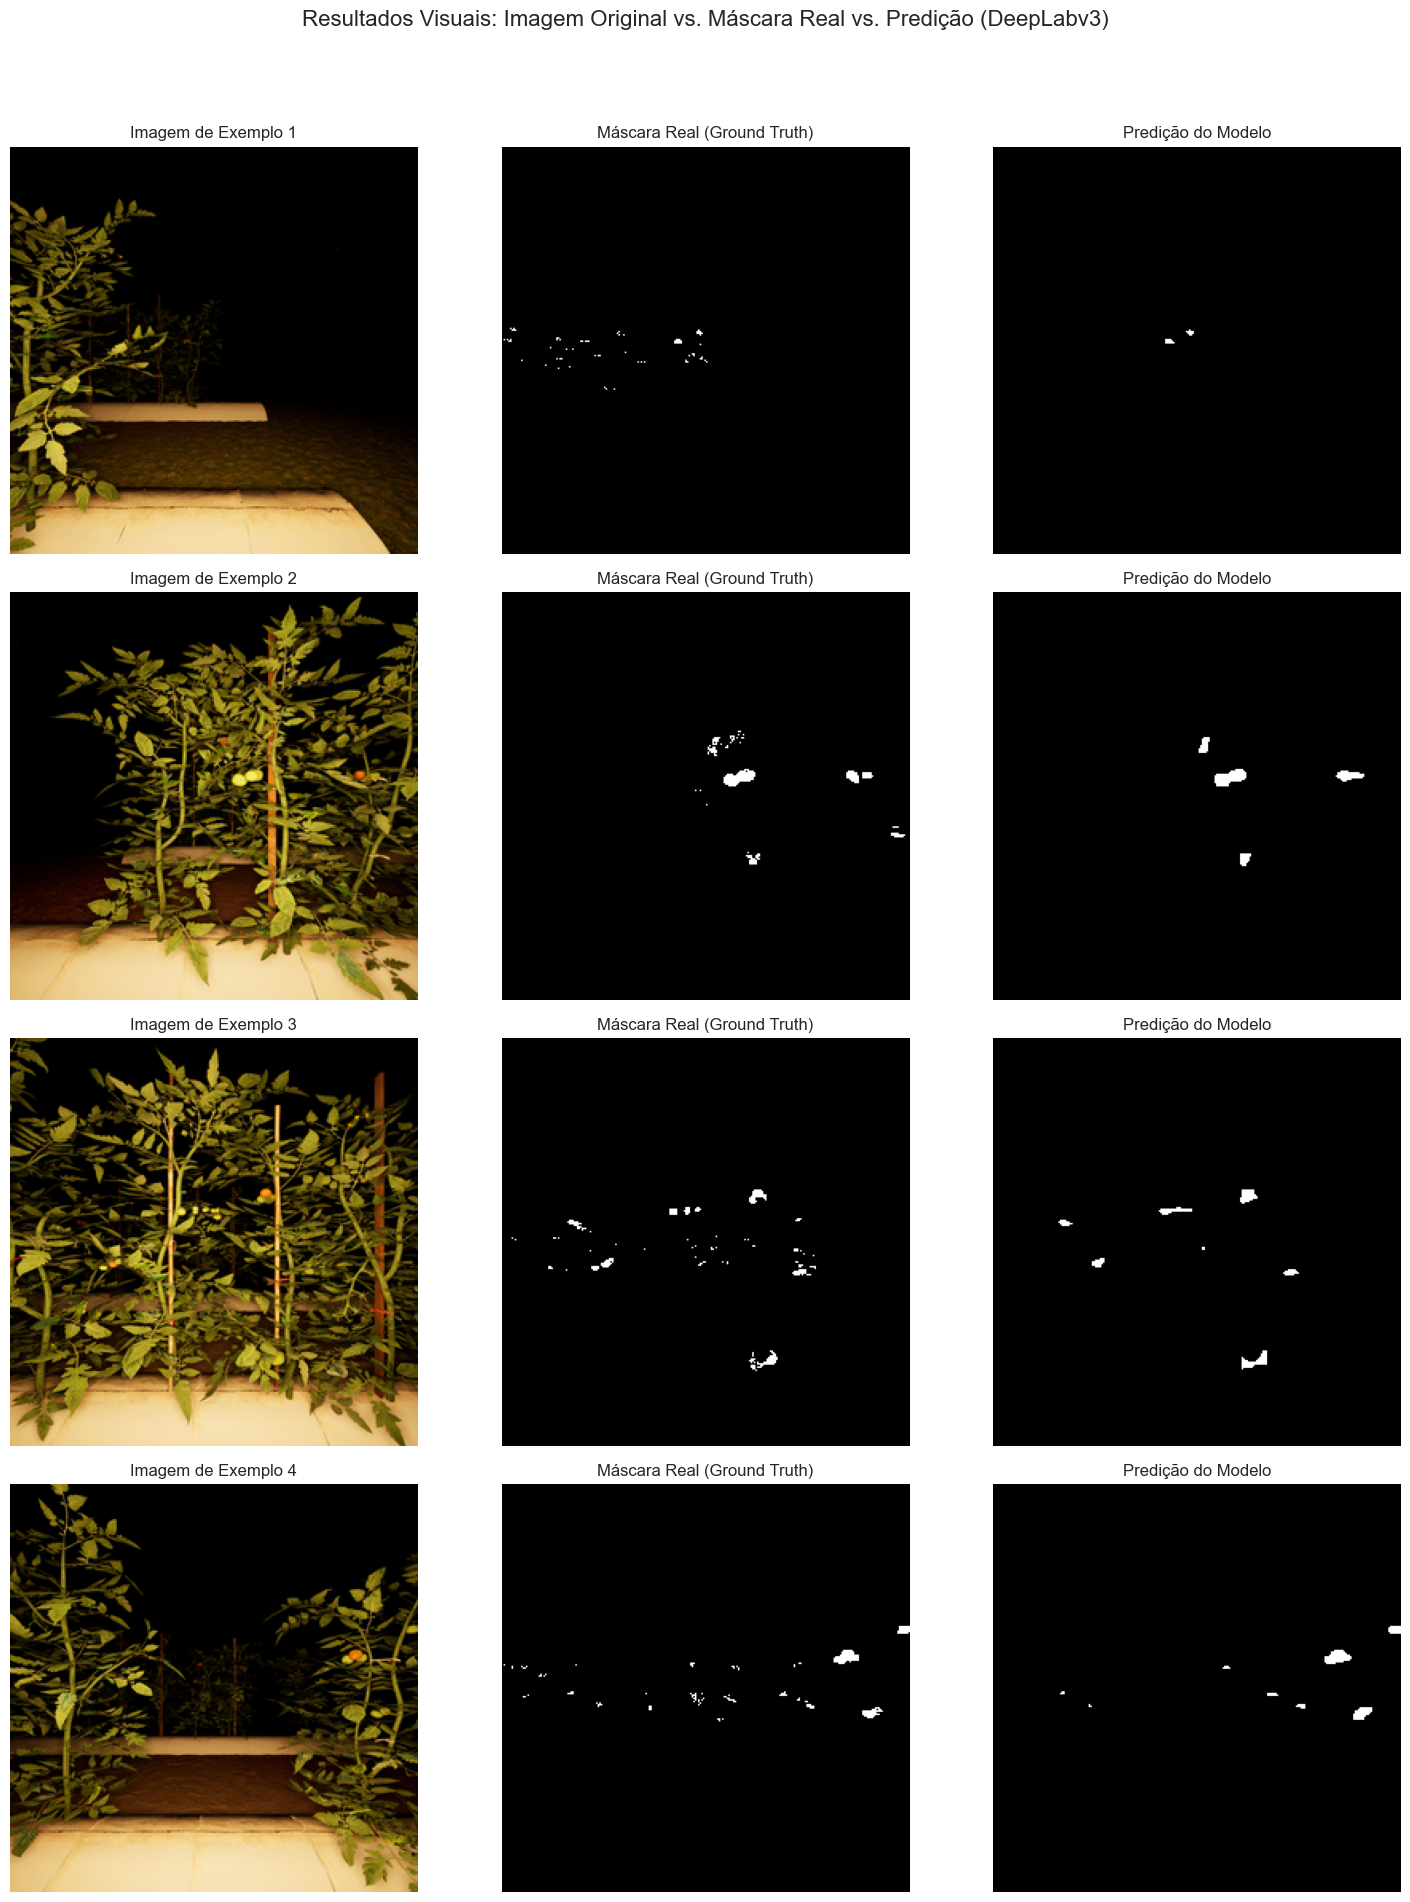

In [52]:
# ===================================================================
# CÉLULA 11: ANÁLISE FINAL CORRIGIDA PARA DEEPLABV3 (SUBSTITUIR)
# ===================================================================

# Configura o estilo dos gráficos
sns.set_theme(style="whitegrid")

# --- 1. CARREGAR DADOS E O MELHOR MODELO DEEPLABV3 ---
print(f"Carregando o melhor modelo DeepLabv3 salvo de '{MODEL_SAVE_PATH}'...")

# CORREÇÃO: Carrega a arquitetura correta (DeepLabv3) antes de carregar os pesos
analysis_model = get_deeplabv3_model(num_classes=1).to(DEVICE)
analysis_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
analysis_model.eval() # Coloca o modelo em modo de avaliação definitivo

print(f"Carregando log de treinamento de '{CSV_LOG_PATH}'...")
log_df = pd.read_csv(CSV_LOG_PATH)


# --- 2. GERAR GRÁFICOS DE TREINAMENTO ---
print("Gerando gráficos de treinamento...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise Completa do Treinamento - DeepLabv3', fontsize=18)

# Gráfico 1: Loss de Treino
sns.lineplot(x='epoch', y='train_loss', data=log_df, ax=ax1, color='blue', label='Train Loss')
ax1.set_title('Loss de Treinamento por Época')
ax1.set_xlabel('Época')
ax1.set_ylabel('Dice+BCE Loss')

# Gráfico 2: Métricas de Validação
sns.lineplot(x='epoch', y='val_iou', data=log_df, ax=ax2, color='green', label='Validation IoU')
sns.lineplot(x='epoch', y='val_dice', data=log_df, ax=ax2, color='red', label='Validation Dice/F1')
ax2.set_title('Métricas de Validação por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('Score')
ax2.legend()

# Gráfico 3: Taxa de Aprendizado
sns.lineplot(x='epoch', y='learning_rate', data=log_df, ax=ax3, color='purple', label='Learning Rate')
ax3.set_title('Taxa de Aprendizado por Época')
ax3.set_xlabel('Época')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. CÁLCULO DE MÉTRICAS FINAIS DETALHADAS ---
# A função calculate_final_metrics precisa ser ajustada para o DeepLabv3 também
def calculate_final_metrics_deeplab(loader, model, device):
    print("\nCalculando métricas finais detalhadas no conjunto de validação...")
    dice_scores, iou_scores, precisions, recalls = [], [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculando Métricas Finais"):
            x, y = x.to(device), y.to(device)
            
            # CORREÇÃO: Usa a saída em dicionário do DeepLabv3
            preds_logits = model(x)['out']
            preds = torch.sigmoid(preds_logits)
            preds = (preds > 0.5).float()
            
            tp = (preds * y).sum()
            fp = ((1 - y) * preds).sum()
            fn = (y * (1 - preds)).sum()
            
            precision = (tp + 1e-6) / (tp + fp + 1e-6)
            recall = (tp + 1e-6) / (tp + fn + 1e-6)
            dice = (2 * tp + 1e-6) / (2 * tp + fp + fn + 1e-6)
            iou = (tp + 1e-6) / (tp + fp + fn + 1e-6)
            
            precisions.append(precision.item())
            recalls.append(recall.item())
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    final_metrics = {
        "IoU": np.mean(iou_scores),
        "Dice/F1": np.mean(dice_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }
    return final_metrics

final_metrics = calculate_final_metrics_deeplab(val_loader, analysis_model, DEVICE)


# --- 4. EXIBIR TABELA DE RESULTADOS FINAIS ---
print("\n" + "="*40)
print("      RESULTADOS FINAIS DO MELHOR MODELO (DeepLabv3)")
print("="*40)
for metric, value in final_metrics.items():
    print(f"{metric:<12}: {value:.4f}")
print("="*40 + "\n")


# --- 5. VISUALIZAÇÃO QUALITATIVA DAS PREDIÇÕES ---
print("Gerando visualizações de predições do melhor modelo DeepLabv3...")
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
val_images, val_masks = next(iter(val_loader))
num_images = min(5, len(val_images))

fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
fig.suptitle('Resultados Visuais: Imagem Original vs. Máscara Real vs. Predição (DeepLabv3)', fontsize=16)

for i in range(num_images):
    image_tensor = val_images[i].to(DEVICE)
    true_mask_np = val_masks[i].squeeze().cpu().numpy()
    
    with torch.no_grad():
        # CORREÇÃO: Usa a saída em dicionário do DeepLabv3
        pred_mask = analysis_model(image_tensor.unsqueeze(0))['out']
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask_np = (pred_mask > 0.5).float().squeeze().cpu().numpy()

    image_display = inv_normalize(image_tensor).cpu().permute(1, 2, 0).numpy()

    axs[i, 0].imshow(np.clip(image_display, 0, 1))
    axs[i, 0].set_title(f"Imagem de Exemplo {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_mask_np, cmap='gray')
    axs[i, 1].set_title("Máscara Real (Ground Truth)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_mask_np, cmap='gray')
    axs[i, 2].set_title("Predição do Modelo")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()